In [1]:
from codes.data_utils import set_seed

import codes.Spain.data_utils_spain
import codes.Spain.preprocess_covid_spain
import importlib
import codes.data_utils

importlib.reload(codes.Spain.data_utils_spain)
importlib.reload(codes.Spain.preprocess_covid_spain)
importlib.reload(codes.data_utils)

from codes.Spain.data_utils_spain import *
from codes.Spain.preprocess_covid_spain import *
from codes.data_utils import *

In [2]:
set_seed(42)
centrality_df = pd.read_csv("data/Spain/centrality_provinces.csv")

In [3]:
mobility_df = clean_spanish_mobility_data(
    file_path="data/Spain/Spanish-Mobility-Raw.xlsx",
    centrality_path="data/Spain/centrality_provinces.csv",
    save_path="data/Spain/mobility_cleaned_final.csv"
)

cities = sorted(set(mobility_df['origin']).union(set(mobility_df['destination'])))
cities_index = {cid: i for i, cid in enumerate(cities)}
N = len(cities)
print(f"Number of Cities: {N}")

avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['origin'], row['destination'], row['weight']
    avg_matrix.at[i, j] = w
    
print("Shape of avg_matrix:", avg_matrix.shape)

[✓] Final cleaned mobility data saved to: data/Spain/mobility_cleaned_final.csv
Number of Cities: 52
Shape of avg_matrix: (52, 52)


In [4]:
cities = sorted(centrality_df['nomemun'].unique())
avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['PROVINCIA ORIGEN'], row['PROVINCIA DESTINO'], row['weight']
    avg_matrix.at[i, j] = w

backbone_df = extract_backbone_from_avg_matrix(avg_matrix, cities, alpha=0.01, top_k=5)
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)
print(f"Backbone extracted with {len(backbone_df)} edges")
backbone_df.shape

[✓] Extracting backbone using pij < 0.01 and top-5 neighbors
[✓] Filtered down to 275 edges from 2478
[✓] Graph built with 52 nodes and 180 edges.
[✓] Converted to PyTorch Geometric format.
Backbone extracted with 275 edges


(275, 7)

In [5]:
# Normalize edges so (A, B) and (B, A) are treated the same
normalized_edges = backbone_df.apply(
    lambda row: tuple(sorted([row['source'], row['target']])), axis=1
)

num_unique_edges = len(set(normalized_edges))
print(f"Unique undirected edges: {num_unique_edges}")

Unique undirected edges: 180


In [6]:
df_covid = pd.read_csv("data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv")
filtered_covid_df = filter_and_scale_spanish_covid_by_centrality(df_covid)

city_case_counts = filtered_covid_df['cod_ine'].value_counts().sort_index()
print(city_case_counts)

[✓] Found saved preprocessed COVID data at 'data/Spain/filtered_scaled_covid.csv'. Loading...
cod_ine
0     786
1     786
2     786
3     786
4     786
5     786
6     786
7     786
8     786
9     786
10    786
11    786
12    786
13    786
14    786
15    786
16    786
17    786
18    786
19    786
20    786
21    786
22    786
23    786
24    786
25    786
26    786
27    786
28    786
29    786
30    786
31    786
32    786
33    786
34    786
35    786
36    786
37    786
38    786
39    786
40    786
41    786
42    786
43    786
44    786
45    786
46    786
47    786
48    786
49    786
50    786
51    786
Name: count, dtype: int64


In [7]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [81]:
# Rename columns for compatibility
spain_covid_df = (
    filtered_covid_df
    .rename(columns={"cod_ine": "ibgeID", "Fecha": "date"})  # 🔁 Rename to match expected schema
)


X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    spain_covid_df,
    input_window=5,
    output_window=1,
    feature_column="z_newCases",
    device=device,
    train_split=0.5
)

[✓] Sliding window: X torch.Size([781, 5, 52, 1]), Y torch.Size([781, 1, 52, 1])
[✓] Train: torch.Size([390, 5, 52, 1]), Test: torch.Size([391, 5, 52, 1])


In [82]:
import codes.models.custom_gcn_transformer_parallel
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.custom_gcn_transformer_parallel)

from codes.models.custom_gcn_transformer_parallel import SpatioTemporalFusionNet

N = pyg_data.num_nodes

model = SpatioTemporalFusionNet(
    in_channels=1,           # number of time-series features per node (e.g., newCases)
    graph_feat_dim=0,        # number of static node features (e.g., population, centrality, etc.)
    trans_hidden=128,         # hidden dim for transformer and GCN
    out_channels=1,          # output features per node (e.g., predicting next-day cases)
    num_nodes=N              # number of nodes in the graph used for graph embeddings
).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # reduce LR by half every 5 epochs

In [83]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [84]:
batch_size = 128  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [85]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [86]:
from tqdm import tqdm

num_epochs = 20
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"🧠 Epoch {epoch+1}/{num_epochs}", position=0, leave=True)

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)  # from [B, 1, N, 1] → [B, N, 1]

        optimizer.zero_grad()
        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current_lr = optimizer.param_groups[0]['lr']

        # Live update of progress bar
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "LR": f"{current_lr:.6f}"
        })

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")
    scheduler.step()

🧠 Epoch 1/20: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, Loss=0.1144, LR=0.001000]


✅ Epoch 1/20 — Avg Loss: 0.3221


🧠 Epoch 2/20: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, Loss=0.0430, LR=0.001000]


✅ Epoch 2/20 — Avg Loss: 0.1033


🧠 Epoch 3/20: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, Loss=0.0908, LR=0.001000]


✅ Epoch 3/20 — Avg Loss: 0.0719


🧠 Epoch 4/20: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, Loss=0.0505, LR=0.001000]


✅ Epoch 4/20 — Avg Loss: 0.0485


🧠 Epoch 5/20: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, Loss=0.1139, LR=0.001000]


✅ Epoch 5/20 — Avg Loss: 0.0668


🧠 Epoch 6/20: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, Loss=0.0280, LR=0.000500]


✅ Epoch 6/20 — Avg Loss: 0.0381


🧠 Epoch 7/20: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, Loss=0.0109, LR=0.000500]


✅ Epoch 7/20 — Avg Loss: 0.0328


🧠 Epoch 8/20: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s, Loss=0.0173, LR=0.000500]


✅ Epoch 8/20 — Avg Loss: 0.0326


🧠 Epoch 9/20: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, Loss=0.0633, LR=0.000500]


✅ Epoch 9/20 — Avg Loss: 0.0428


🧠 Epoch 10/20: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, Loss=0.0208, LR=0.000500]


✅ Epoch 10/20 — Avg Loss: 0.0322


🧠 Epoch 11/20: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, Loss=0.0270, LR=0.000250]


✅ Epoch 11/20 — Avg Loss: 0.0341


🧠 Epoch 12/20: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, Loss=0.0923, LR=0.000250]


✅ Epoch 12/20 — Avg Loss: 0.0497


🧠 Epoch 13/20: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s, Loss=0.0858, LR=0.000250]


✅ Epoch 13/20 — Avg Loss: 0.0470


🧠 Epoch 14/20: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s, Loss=0.0085, LR=0.000250]


✅ Epoch 14/20 — Avg Loss: 0.0286


🧠 Epoch 15/20: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s, Loss=0.0054, LR=0.000250]


✅ Epoch 15/20 — Avg Loss: 0.0276


🧠 Epoch 16/20: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, Loss=0.0094, LR=0.000125]


✅ Epoch 16/20 — Avg Loss: 0.0286


🧠 Epoch 17/20: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, Loss=0.0264, LR=0.000125]


✅ Epoch 17/20 — Avg Loss: 0.0325


🧠 Epoch 18/20: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, Loss=0.0030, LR=0.000125]


✅ Epoch 18/20 — Avg Loss: 0.0269


🧠 Epoch 19/20: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, Loss=0.0170, LR=0.000125]


✅ Epoch 19/20 — Avg Loss: 0.0302


🧠 Epoch 20/20: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s, Loss=0.0748, LR=0.000125]

✅ Epoch 20/20 — Avg Loss: 0.0438


In [87]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]

        output = model(batch_X, edge_index, edge_weight)  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")


🔍 Testing:   0%|          | 0/4 [00:00<?, ?it/s]/Users/youssefmalek/miniconda3/envs/ML/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([128, 1, 52, 1])) that is different to the input size (torch.Size([128, 52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
🔍 Testing:  75%|███████▌  | 3/4 [00:00<00:00,  7.26it/s, Loss=5.08] /Users/youssefmalek/miniconda3/envs/ML/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7, 1, 52, 1])) that is different to the input size (torch.Size([7, 52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
                                                                     


✅ Final Test Loss: 1.4241


In [88]:
# Flatten actuals: [156, 1, 52, 1] → [156, 52]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()
pred_array = predictions.squeeze(-1).numpy()  # already [156, 52]

print("Pred shape:", pred_array.shape)
print("Actual shape:", actual_array.shape)

Pred shape: (391, 52)
Actual shape: (391, 52)


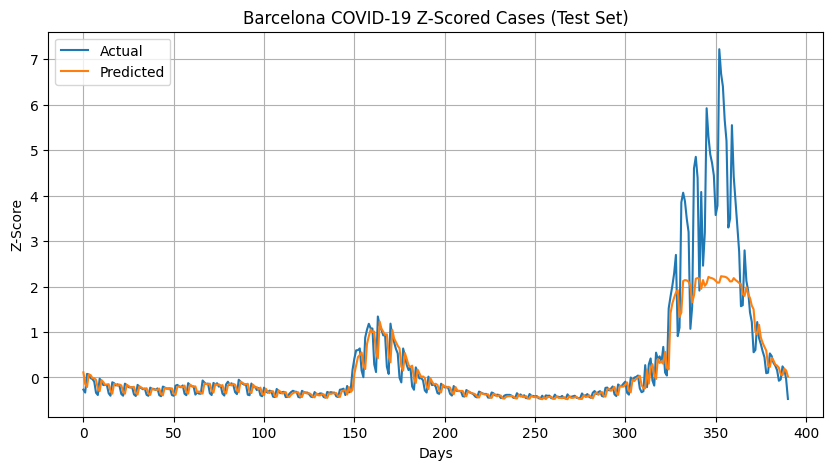

📉 RMSE for Barcelona: 0.7471


In [94]:
import matplotlib.pyplot as plt

city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

barcelona_preds = pred_array[:, barcelona_index]
barcelona_actuals = actual_array[:, barcelona_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual')
plt.plot(barcelona_preds, label='Predicted')
plt.title("Barcelona COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

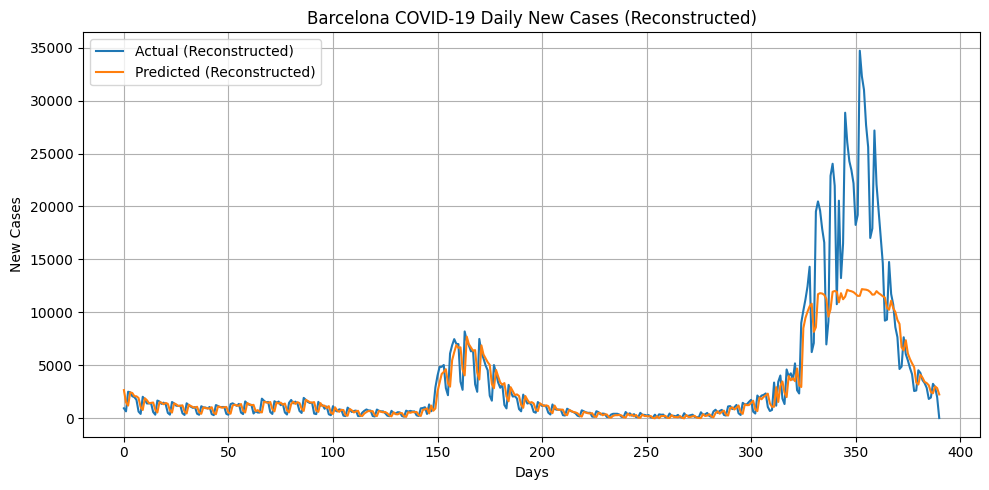

📉 RMSE for Barcelona: 3370.8773


In [93]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph from centrality dataframe
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_name = row['nomemun']
    G2.add_node(city_name)

# Make sure predictions and actuals are [T, N]
pred_array = predictions.squeeze(-1).numpy()        # [T, N]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()  # [T, N]

# Barcelona node name
city_name = "Barcelona"
city_id_list = list(G2.nodes())
barcelona_index = city_id_list.index(city_name)

# Get z-scored predictions and actuals
barcelona_preds_z = pred_array[:, barcelona_index]
barcelona_actuals_z = actual_array[:, barcelona_index]

# 🧠 Reconstruct actual daily cases
sp_original = df_covid[df_covid['provincia'] == city_name].copy()
sp_original['Casos'] = sp_original['Casos'].clip(lower=0)
sp_original = sp_original.sort_values('Fecha')

mean_barcelona = sp_original['Casos'].mean()
std_barcelona = sp_original['Casos'].std(ddof=0)

# 🔁 De-normalize predictions
barcelona_preds = barcelona_preds_z * std_barcelona + mean_barcelona
barcelona_actuals = barcelona_actuals_z * std_barcelona + mean_barcelona

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual (Reconstructed)')
plt.plot(barcelona_preds, label='Predicted (Reconstructed)')
plt.title("Barcelona COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")


In [95]:
# Filter São Paulo full series
sp_full = filtered_covid_df[filtered_covid_df['provincia'] == city_name].sort_values('Fecha')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['Fecha'].tolist()

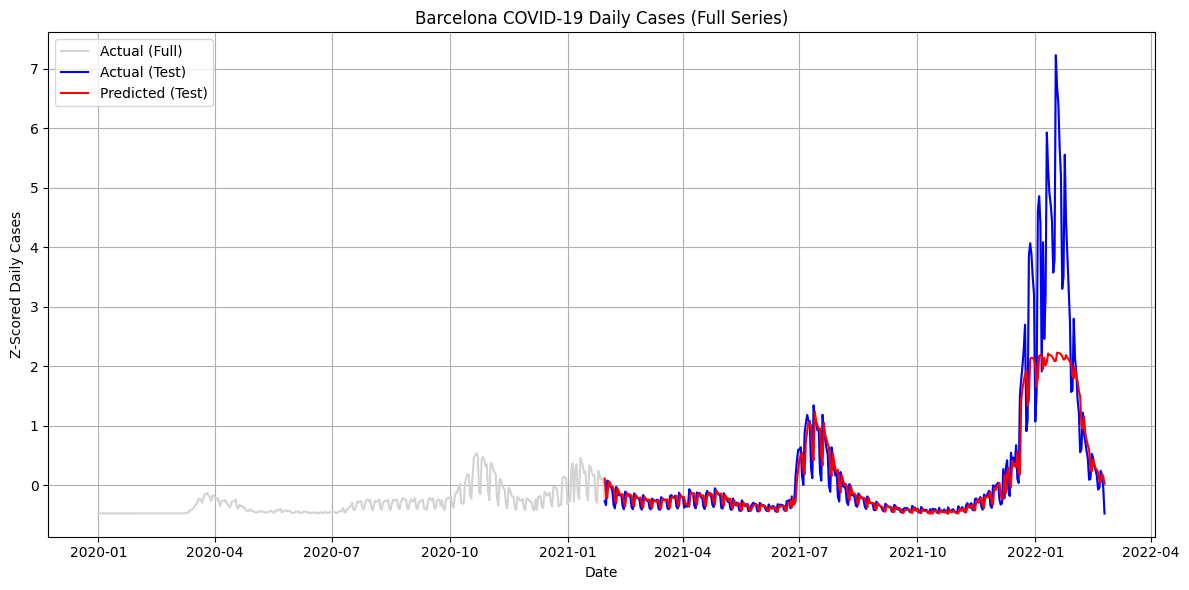

📉 RMSE for Barcelona: 0.7471


In [96]:
# Find index where test set starts (80% of the full time series segments)
start_index = len(full_z_series) - len(barcelona_actuals)

plt.figure(figsize=(12, 6))
plt.plot(full_dates, full_z_series, label='Actual (Full)', color='lightgray')
plt.plot(full_dates[start_index:], barcelona_actuals, label='Actual (Test)', color='blue')
plt.plot(full_dates[start_index:], barcelona_preds, label='Predicted (Test)', color='red')
plt.title("Barcelona COVID-19 Daily Cases (Full Series)")
plt.xlabel("Date")
plt.ylabel("Z-Scored Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_sp:.4f}")



In [97]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")


📊 Average RMSE across all cities: 0.7185


In [98]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: Pontevedra — RMSE: 0.8462
City ID: Ávila — RMSE: 0.8402
City ID: Bizkaia — RMSE: 0.8254
City ID: León — RMSE: 0.7992
City ID: Castellón/Castelló — RMSE: 0.7903

✅ Top 5 cities with lowest RMSE:
City ID: A Coruña — RMSE: 0.5597
City ID: Lleida — RMSE: 0.5839
City ID: Cantabria — RMSE: 0.5967
City ID: Córdoba — RMSE: 0.6279
City ID: Cuenca — RMSE: 0.6425


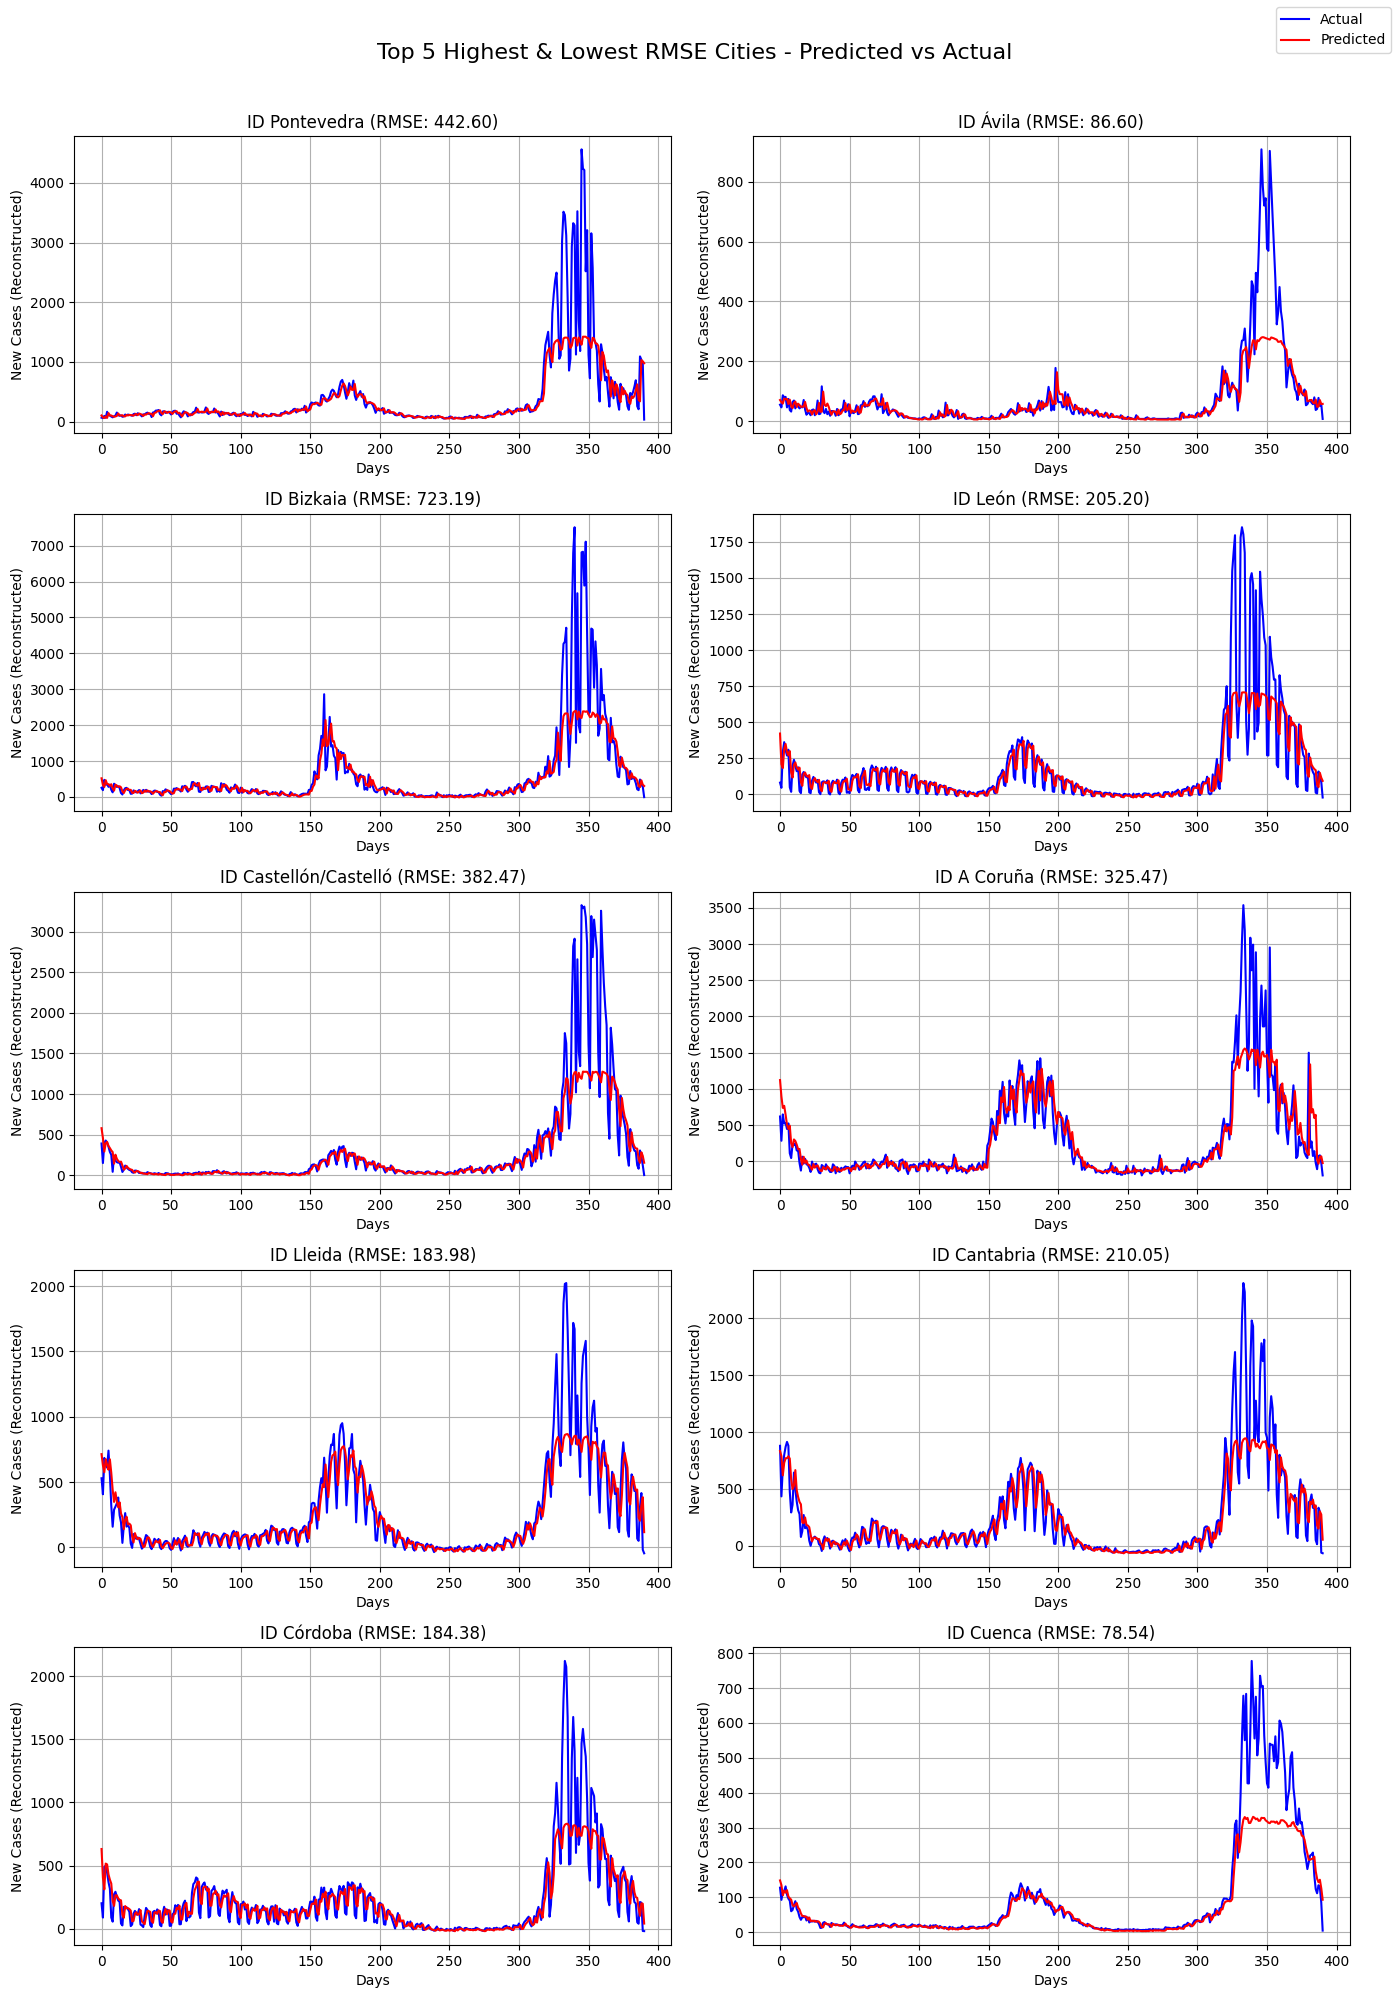

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = df_covid[df_covid['provincia'] == city_id].copy()
    city_data['Casos'] = city_data['Casos'].clip(lower=0)
    mean = city_data['Casos'].mean()
    std = city_data['Casos'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [100]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/GCN-Transformer-Spain-4.pth")